# Alarm Alert/Type Prediction

# Loading Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import dill as pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from datetime import datetime

# Loading Alarm Alert Data

In [2]:
alarm_data = pd.read_csv('./Bangalore-CAS-alerts/bangalore-cas-alerts.csv',
                         index_col=None,encoding = 'ISO-8859-1')

# Checking Data

In [3]:
#Top 5 rows of data
alarm_data.head()

,device_code,latitude,longitude,ward_name,alarm_type,speed,time_date
0,8.650000e+14,12.984595,77.744087,Kadugodi,PCW,32,2018-02-01T01:48:59.000Z
1,8.650000e+14,12.984595,77.744087,Kadugodi,PCW,32,2018-02-01T01:48:59.000Z
2,8.650000e+14,12.987233,77.741119,Garudachar Playa,FCW,41,2018-02-01T01:50:00.000Z
3,8.650000e+14,12.987233,77.741119,Garudachar Playa,FCW,41,2018-02-01T01:50:00.000Z
4,8.650000e+14,12.987503,77.740051,Hudi,Overspeed,37,2018-02-01T01:50:11.000Z


In [4]:
#check the columns names
alarm_data.columns

Index(['device_code', 'latitude', 'longitude', 'ward_name', 'alarm_type',
       'speed', 'time_date'],
      dtype='object')

In [5]:
#Checking data type
alarm_data.dtypes

device_code    float64
latitude       float64
longitude      float64
ward_name       object
alarm_type      object
speed            int64
time_date       object
dtype: object

In [6]:
#Checking missing values in data
alarm_data.isnull().sum()

device_code    0
latitude       0
longitude      0
ward_name      0
alarm_type     0
speed          0
time_date      0
dtype: int64

In [7]:
#creating a copy of alarm data
alarm_df = alarm_data.copy()

In [8]:
#info about data
alarm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207617 entries, 0 to 207616
Data columns (total 7 columns):
device_code    207617 non-null float64
latitude       207617 non-null float64
longitude      207617 non-null float64
ward_name      207617 non-null object
alarm_type     207617 non-null object
speed          207617 non-null int64
time_date      207617 non-null object
dtypes: float64(3), int64(1), object(3)
memory usage: 11.1+ MB


In [9]:
#Summary of given data
alarm_df.describe()

,device_code,latitude,longitude,speed
count,2.076170e+05,207617.000000,207617.000000,207617.000000
mean,8.643135e+14,12.970551,77.721926,22.198341
std,4.978744e+11,0.027337,0.029808,13.750137
min,8.620000e+14,12.686663,77.508179,0.000000
25%,8.640000e+14,12.956460,77.707352,11.000000
50%,8.640000e+14,12.973270,77.727448,22.000000
75%,8.650000e+14,12.987865,77.743668,32.000000
max,8.650000e+14,13.070075,77.806824,83.000000


# Data Cleaning and Preprocessing

In [10]:
#Data cleaning-----------------------------------------------------------------------------------
#extracting day & hour variable from given date
alarm_df['day'] = [datetime.strptime(d, '%Y-%m-%dT%H:%M:%S.000Z').weekday() for d in alarm_df['time_date']]
alarm_df['hour'] = [datetime.strptime(d, '%Y-%m-%dT%H:%M:%S.000Z').hour for d in alarm_df['time_date']]

# Feature Engineering

In [11]:
#creating Var1 - Mean of acceleration for every bus no.
df_1 =  alarm_df.groupby(['alarm_type','ward_name'])['speed'].mean().to_frame()
df_1.columns = ['mean_speed_ward_name']  
df_1['alarm_type'] = [df_1.index[i][0] for i in range(len(df_1))]
df_1['ward_name'] = [df_1.index[j][1] for j in range(len(df_1))]

df_1.reset_index(drop = True, inplace = True)
df_1.head()      

df_data_1 = pd.merge(alarm_df,df_1,how = 'inner',on = ['ward_name','alarm_type'],left_index = False,right_index = False)

df_data_1.head()

,device_code,latitude,longitude,ward_name,alarm_type,speed,time_date,day,hour,mean_speed_ward_name
0,8.650000e+14,12.984595,77.744087,Kadugodi,PCW,32,2018-02-01T01:48:59.000Z,3,1,20.82283
1,8.650000e+14,12.984595,77.744087,Kadugodi,PCW,32,2018-02-01T01:48:59.000Z,3,1,20.82283
2,8.650000e+14,12.987670,77.738075,Kadugodi,PCW,16,2018-02-01T02:09:07.000Z,3,2,20.82283
3,8.650000e+14,12.987670,77.738075,Kadugodi,PCW,16,2018-02-01T02:09:07.000Z,3,2,20.82283
4,8.650000e+14,12.986483,77.744751,Kadugodi,PCW,11,2018-02-01T02:11:15.000Z,3,2,20.82283


In [12]:
#data preparation for modelling-----------------------------------------------------------------
#Converting route variable (object) to integer [Label Encoding]
cat_col = ['ward_name']
for var in cat_col:
    le = preprocessing.LabelEncoder()
    df_data_1[var]=le.fit_transform(df_data_1[var].astype('str'))

# Feature Analysis

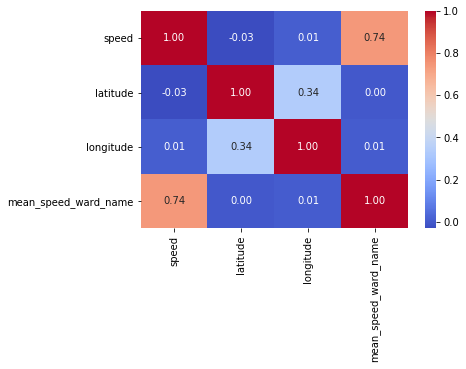

In [13]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(df_data_1[['speed','latitude', 'longitude','mean_speed_ward_name']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

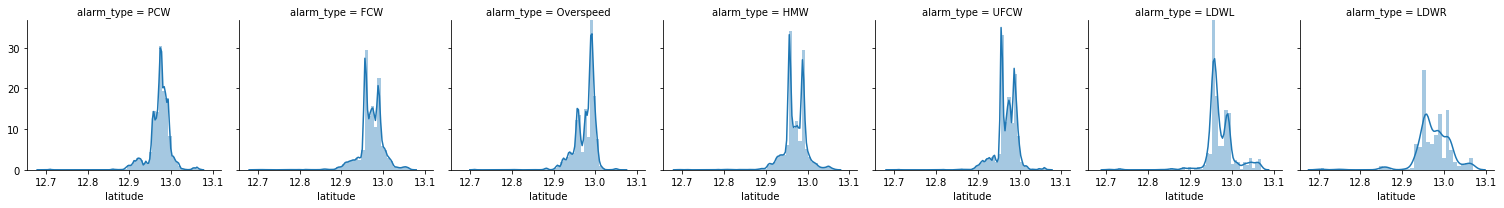

In [14]:
# Explore Latitude vs Event Name
g = sns.FacetGrid(df_data_1, col='alarm_type')
g = g.map(sns.distplot, "latitude")

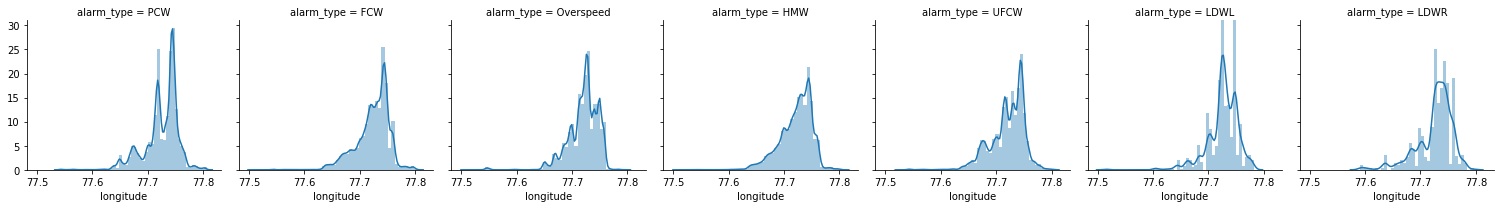

In [15]:
# Explore Latitude vs Event Name
g = sns.FacetGrid(df_data_1, col='alarm_type')
g = g.map(sns.distplot, "longitude")

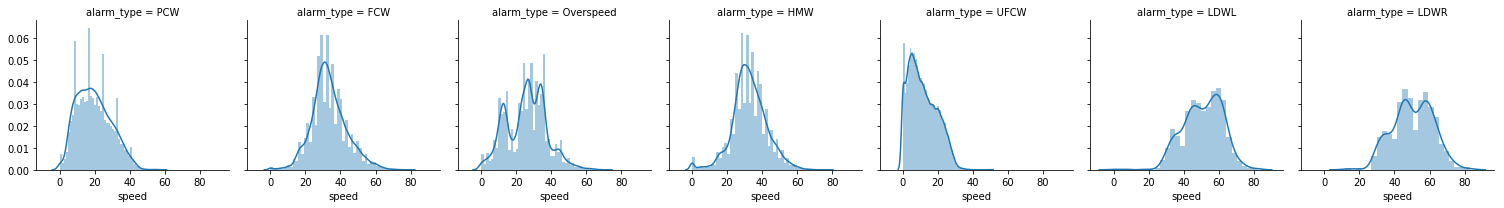

In [16]:
# Explore Latitude vs Event Name
g = sns.FacetGrid(df_data_1, col='alarm_type')
g = g.map(sns.distplot, "speed")

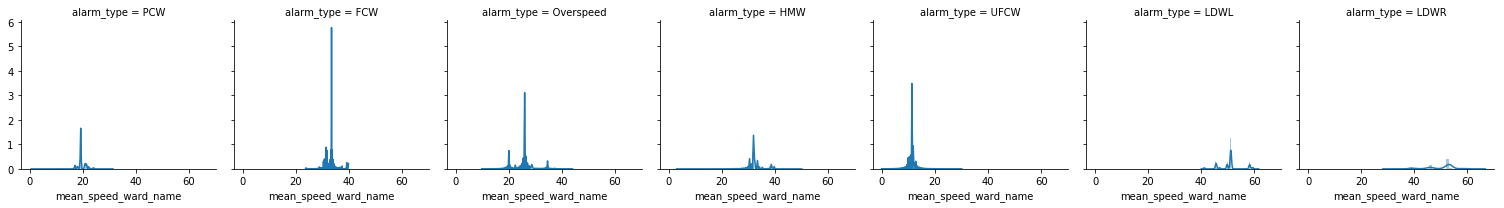

In [17]:
# Explore Latitude vs Event Name
g = sns.FacetGrid(df_data_1, col='alarm_type')
g = g.map(sns.distplot, "mean_speed_ward_name")

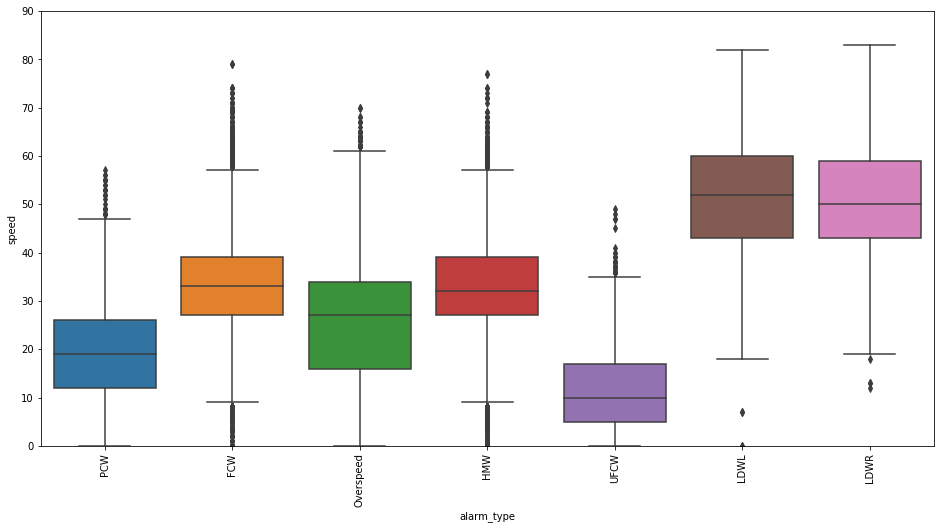

In [18]:
#boxplots for speed variables
var = 'alarm_type'
data = pd.concat([df_data_1['speed'], df_data_1[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y='speed', data=data)
fig.axis(ymin=0, ymax=90);
plt.xticks(rotation=90);

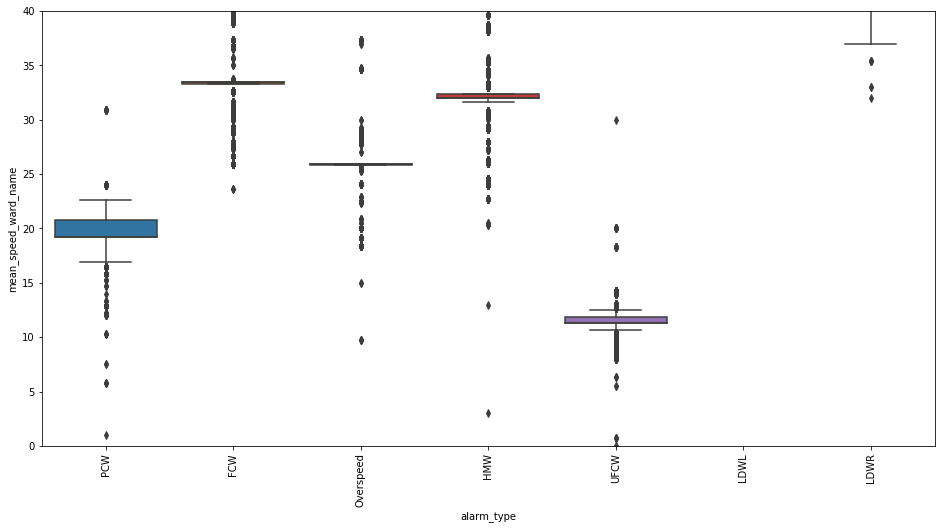

In [19]:
var = 'alarm_type'
data = pd.concat([df_data_1['mean_speed_ward_name'], df_data_1[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y='mean_speed_ward_name', data=data)
fig.axis(ymin=0, ymax=40);
plt.xticks(rotation=90);

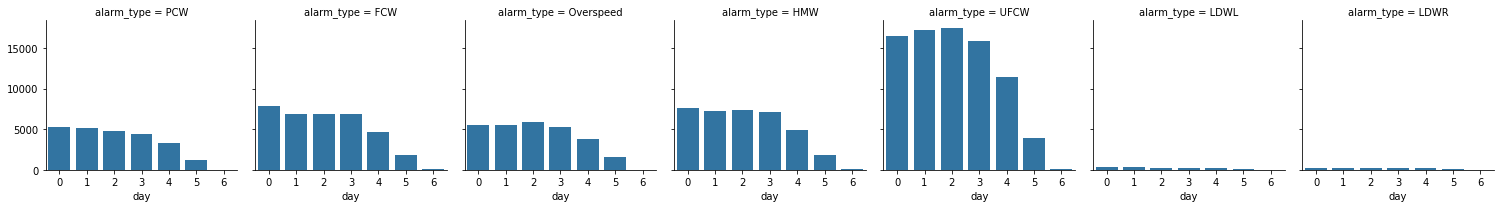

In [20]:
# Explore Day vs Event Name
g = sns.FacetGrid(df_data_1, col='alarm_type')
g = g.map(sns.countplot, "day")

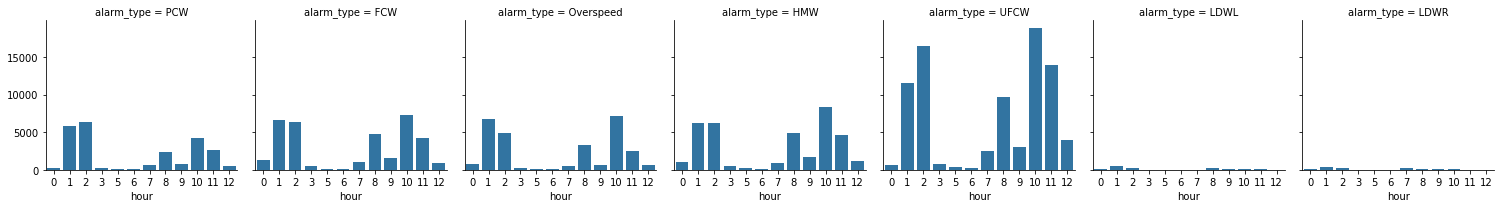

In [21]:
# Explore Day vs Event Name
g = sns.FacetGrid(df_data_1, col='alarm_type')
g = g.map(sns.countplot, "hour")

# Modeling

In [22]:
#XGBoost function
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=1000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = len(np.unique(df_data_1['alarm_type']))
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [23]:
#Preparation data for xgboost model
#Coverting event name (target) to numerical
target_num_map = {'FCW':0, 'HMW':1, 'LDWL':2, 'LDWR':3, 'Overspeed':4, 'PCW':5, 'UFCW':6}
df_data_1['alarm_type'] = df_data_1['alarm_type'].apply(lambda x: target_num_map[x])

In [24]:
#Splitting the dataset into traninig and testing

cols_to_use = ['day','hour','speed','latitude', 'longitude','mean_speed_ward_name']


train, test = train_test_split(df_data_1, test_size=0.3,random_state = 100)

X_train = train.loc[:,cols_to_use]
Y_train = train['alarm_type']

X_test = test.loc[:,cols_to_use]
Y_test = test['alarm_type']

print(X_train.shape)
print(X_test.shape)

(145331, 6)
(62286, 6)


In [25]:
cv_scores = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=216)
for dev_index, val_index in kf.split(range(X_train.shape[0])):
        dev_X, val_X = np.array(X_train)[dev_index,:], np.array(X_train)[val_index,:]
        dev_y, val_y = np.array(Y_train)[dev_index], np.array(Y_train)[val_index]
        preds, model = runXGB(dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        print(cv_scores)
        break

[0]	train-mlogloss:1.66294	test-mlogloss:1.66391
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:1.56139	test-mlogloss:1.56255
[2]	train-mlogloss:1.36556	test-mlogloss:1.36672
[3]	train-mlogloss:1.18914	test-mlogloss:1.19013
[4]	train-mlogloss:1.06271	test-mlogloss:1.06357
[5]	train-mlogloss:0.952991	test-mlogloss:0.953659
[6]	train-mlogloss:0.847518	test-mlogloss:0.848092
[7]	train-mlogloss:0.770664	test-mlogloss:0.771304
[8]	train-mlogloss:0.710497	test-mlogloss:0.711263
[9]	train-mlogloss:0.652933	test-mlogloss:0.653721
[10]	train-mlogloss:0.602343	test-mlogloss:0.603138
[11]	train-mlogloss:0.553746	test-mlogloss:0.554516
[12]	train-mlogloss:0.511428	test-mlogloss:0.512251
[13]	train-mlogloss:0.472283	test-mlogloss:0.47305
[14]	train-mlogloss:0.444288	test-mlogloss:0.445193
[15]	train-mlogloss:0.423743	test-mlogloss:0.42482
[16]	train-mlogloss:0.386908	test-mlogl

[155]	train-mlogloss:0.001021	test-mlogloss:0.002608
[156]	train-mlogloss:0.001012	test-mlogloss:0.002605
[157]	train-mlogloss:0.001004	test-mlogloss:0.002607
[158]	train-mlogloss:0.000984	test-mlogloss:0.002583
[159]	train-mlogloss:0.000968	test-mlogloss:0.002571
[160]	train-mlogloss:0.000952	test-mlogloss:0.002559
[161]	train-mlogloss:0.000939	test-mlogloss:0.002549
[162]	train-mlogloss:0.000919	test-mlogloss:0.002531
[163]	train-mlogloss:0.000907	test-mlogloss:0.002522
[164]	train-mlogloss:0.00089	test-mlogloss:0.002503
[165]	train-mlogloss:0.000882	test-mlogloss:0.002502
[166]	train-mlogloss:0.00087	test-mlogloss:0.002499
[167]	train-mlogloss:0.000856	test-mlogloss:0.002483
[168]	train-mlogloss:0.000844	test-mlogloss:0.002479
[169]	train-mlogloss:0.000831	test-mlogloss:0.002471
[170]	train-mlogloss:0.000815	test-mlogloss:0.002452
[171]	train-mlogloss:0.000802	test-mlogloss:0.002439
[172]	train-mlogloss:0.00079	test-mlogloss:0.002426
[173]	train-mlogloss:0.000781	test-mlogloss:0.002

[311]	train-mlogloss:0.000285	test-mlogloss:0.002091
[312]	train-mlogloss:0.000285	test-mlogloss:0.002092
[313]	train-mlogloss:0.000283	test-mlogloss:0.002094
[314]	train-mlogloss:0.000281	test-mlogloss:0.00209
[315]	train-mlogloss:0.000281	test-mlogloss:0.002089
[316]	train-mlogloss:0.00028	test-mlogloss:0.002085
[317]	train-mlogloss:0.000279	test-mlogloss:0.002084
[318]	train-mlogloss:0.000278	test-mlogloss:0.002086
[319]	train-mlogloss:0.000277	test-mlogloss:0.002086
[320]	train-mlogloss:0.000276	test-mlogloss:0.002086
[321]	train-mlogloss:0.000275	test-mlogloss:0.002085
[322]	train-mlogloss:0.000274	test-mlogloss:0.002083
[323]	train-mlogloss:0.000273	test-mlogloss:0.002083
[324]	train-mlogloss:0.000272	test-mlogloss:0.002086
[325]	train-mlogloss:0.000271	test-mlogloss:0.002083
[326]	train-mlogloss:0.00027	test-mlogloss:0.002083
[327]	train-mlogloss:0.000269	test-mlogloss:0.002082
[328]	train-mlogloss:0.000268	test-mlogloss:0.002081
[329]	train-mlogloss:0.000267	test-mlogloss:0.002

In [26]:
preds, model = runXGB(X_train, Y_train, X_test, num_rounds=400)
probs = np.ones((len(Y_test), 7))
probs = np.multiply(probs, preds)
preds = np.array([np.argmax(prob) for prob in preds])

#f1_score
score = f1_score(Y_test, preds, average='weighted')
print(score)

0.9996467844254157


In [27]:
# Confusion plot

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix


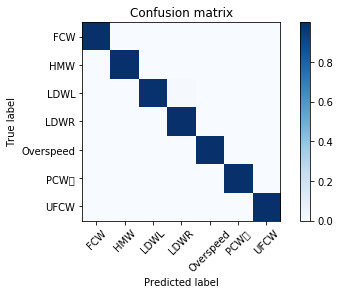

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, preds)
np.set_printoptions(precision=2)
# Plot confusion matrix
unique_type_list = ['FCW', 'HMW', 'LDWL', 'LDWR', 'Overspeed', 'PCW	','UFCW']
lab_encoder = LabelEncoder().fit(unique_type_list)
plot_confusion_matrix(cnf_matrix, classes=lab_encoder.inverse_transform(range(7)), normalize=True,
                      title=('Confusion matrix'))

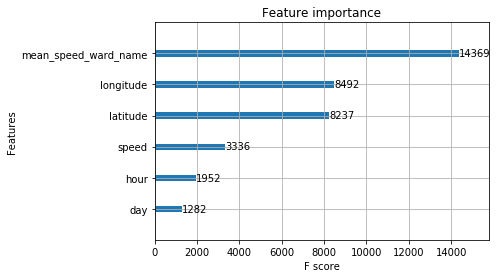

In [30]:
#Variable importance by xgboost
xgb.plot_importance(model)

In [31]:
#Pickle the model
filename = 'model_v1_alarm_alert.pk'
with open('./scripts/alarm_alert/'filename, 'wb') as file:
	pickle.dump(model, file)